In this notebook I'll investigate the distribution of the Dickey Fuller statistic, which is the t statistic for the process 
$
    r_t = \phi_0 + \phi_1 r_{t-1} + \varepsilon_t
$
Here we'll assume the drift term is zero ($\phi_0 = 0$).

Under the null hypothesis $\phi_1 = 1$ so $r_t$ is a random walk. 
We'll assume that $\mathrm{Var}(\varepsilon_t) = \sigma^2 = 0.02^2$

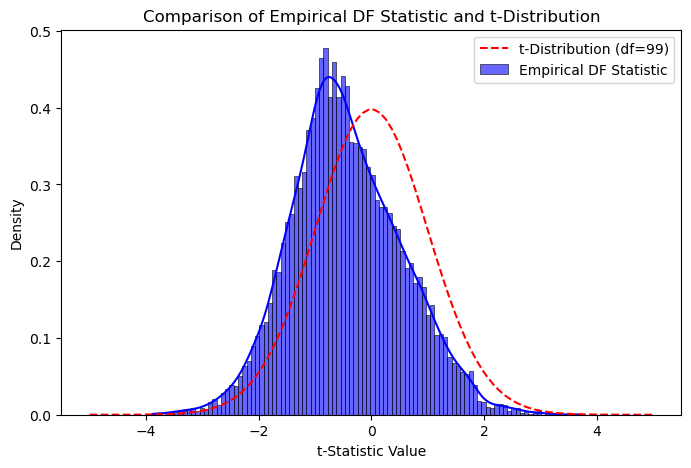

In [2]:
import numpy as np
import statsmodels.api as sm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

def simulate_random_walk(n_sims, steps, x0, sigma):
    rng = np.random.default_rng()
    dx = rng.normal(loc=0, scale=sigma, size=(n_sims, steps))
    displacement = np.cumsum(dx, axis=1)
    rw = np.hstack((np.full((n_sims, 1), x0), x0 + displacement))  
    return rw

def compute_t_stat(rw):
    y = rw[1:]
    X = rw[:-1][:, np.newaxis]  
    lm = sm.OLS(y, X).fit()
    return (lm.params[0] - 1) / lm.bse[0]  

def simulate_t_stats(n_sims, steps, x0, sigma, n_jobs=-1):
    rws = simulate_random_walk(n_sims, steps, x0, sigma)  
    t_stats = Parallel(n_jobs=n_jobs)(delayed(compute_t_stat)(rw) for rw in rws)
    return np.array(t_stats)

# Parameters
n_sims = 10_000
steps = 100
x0 = 0.05
sigma = 0.02

# Simulate DF statistics
df_stats = simulate_t_stats(n_sims, steps, x0, sigma, n_jobs=-1)

# Plot DF Statistic Distribution vs. t-Distribution
fig, ax = plt.subplots(figsize=(8, 5))

# Plot empirical DF statistic distribution
sns.histplot(df_stats, bins=100, kde=True, stat="density", label="Empirical DF Statistic", color="blue", alpha=0.6)

# Overlay t-distribution (correct DOF = steps - 1)
x = np.linspace(-5, 5, 100)
y = t.pdf(x, df=steps-1)
ax.plot(x, y, 'r--', label=f"t-Distribution (df={steps-1})")

# Labels
ax.set_title("Comparison of Empirical DF Statistic and t-Distribution")
ax.set_xlabel("t-Statistic Value")
ax.set_ylabel("Density")
ax.legend()

plt.show()